In [45]:
from transformers import AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

#word_tokenize = AutoTokenizer.from_pretrained("suayptalha/DeepSeek-R1-Distill-Qwen-0.5B-CoMa")
word_tokenize = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")

def calcular_bleu(texto_gerado, texto_referencia):
    referencia = [word_tokenize(texto_referencia).input_ids]
    gerado = word_tokenize(texto_gerado).input_ids
    smoothie = SmoothingFunction().method1  

    return 1-sentence_bleu(referencia, gerado, smoothing_function=smoothie)

In [46]:
sim_score = calcular_bleu(
    "As a general guideline, how much protein should a female eat",
    "As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day."
)
print(f"\nSimilaridade entre frase e documento: {sim_score:.2f}")
dif_score = 1-sim_score
print(f"\nDiff entre frase e documento: {dif_score:.2f}")


Similaridade entre frase e documento: 0.90

Diff entre frase e documento: 0.10


In [47]:
import requests

def create_completion(prompt, max_tokens, temperature, top_p, top_k):
	try:
		response = requests.post("http://localhost:1234/v1/completions", json={
			"model": "deepseek-r1-distill-qwen-1.5b",
			"prompt": prompt,
			"max_tokens": int(max_tokens),
			"temperature": float(temperature),
			"top_p": float(top_p),
			"top_k": int(top_k),
			"stream": False
		})
		response.raise_for_status()  # Lança erro se o status HTTP for 4xx ou 5xx
		result = response.json()
		return result['choices'][0]['text']
	except Exception as e:
		print("Erro em create_completion:")
		print(f"Prompt: {prompt[:15]}...")
		print(f"Parâmetros: max_tokens={max_tokens}, temperature={temperature}, top_p={top_p}, top_k={top_k}")
		print(f"Erro: {e}")
		exit

In [48]:
from datasets import load_dataset
ds_stream = load_dataset("ccdv/arxiv-summarization", "section", split="test", streaming=True)

In [49]:
import threading
import random

class SampleReservoir:
    def __init__(self, stream, k, max_items=None):
        self.stream = stream
        self.k = k
        self.max_items = max_items
        self.reservoir = []
        self.lock = threading.Lock()
        self.done = False

    def update(self):
        # Algoritmo de amostragem de reservatório com proteção de acesso
        for i, item in enumerate(self.stream):
            if self.max_items is not None and i >= self.max_items:
                break
            with self.lock:
                if i < self.k:
                    self.reservoir.append(item)
                else:
                    j = random.randint(0, i)
                    if j < self.k:
                        self.reservoir[j] = item
        self.done = True
        print("done")

    def get_samples(self):
        with self.lock:
            # Retorna uma cópia do reservoir atual
            return list(self.reservoir)

# Inicializa o objeto do reservoir
reservoir = SampleReservoir(ds_stream, k=5, max_items=5000)

# Inicia a thread de atualização (em background)
update_thread = threading.Thread(target=reservoir.update, daemon=True)
update_thread.start()

done


In [55]:
samples = reservoir.get_samples()
samples

[{'article': 'measurements of the masses and mass - to - light ( @xmath1 ) ratios of early - type galaxies in distant clusters provide important constraints on galaxy evolution . \n the luminosity evolution of early - type galaxies can be determined by comparing the luminosities of galaxies of similar masses at different redshifts . \n also , mass measurements can be used to constrain the merger rate . \n the evolution of the @xmath1 ratio can be measured from the evolution of the fundamental plane of early - type galaxies . the fundamental plane ( fp ) \n is a tight correlation between the structural parameters and the velocity dispersion of the form @xmath17 in the @xmath18 band ( djorgovski & davis 1987 ; dressler et al . \n 1987 ; jrgensen , franx & kjrgaard 1996 [ jfk ] ) . \n assuming homology , the existence of the fp implies that @xmath19 , with low scatter ( faber et al . \n therefore , the evolution of the intercept of the fp is proportional to the evolution of the mean @xmat

In [56]:
from skopt.space import Integer

# Número de tokens que você deseja usar
num_tokens = 60

# Gerar dinamicamente as dimensões dos tokens
token_dimensions = [Integer(0, 151642, name=f'token{i}') for i in range(num_tokens)]

# Adicionar os parâmetros extras ao espaço
space = token_dimensions + [
    Integer(1, 2000, name='temp'),
    Integer(1, 1000, name='top_k'),
    Integer(1, 1000, name='top_p')
]


In [ ]:
from tqdm import tqdm
from skopt.utils import use_named_args
import numpy as np

# Estado global para controle
melhor_bleu_global = 1
samples_cache = None

@use_named_args(space)
def objective(**kwargs):
    global melhor_bleu_global, samples_cache

    temp = round(kwargs['temp'] / 1000, 3)
    top_k = round(kwargs['top_k'] / 1000, 3)
    top_p = round(kwargs['top_p'] / 1000, 3)

    token_keys = [f'token{i}' for i in range(len(kwargs) - 3)]  # os 3 últimos são temp, top_k, top_p
    token_values = [kwargs[k] for k in token_keys]

    # Particiona os tokens em dois blocos de 20
    meio = len(token_values) // 2
    prefix_tokens = token_values[:meio]
    suffix_tokens = token_values[meio:]

    if samples_cache is None:
        samples_cache = reservoir.get_samples()

    bleus = []
    for ex in tqdm(samples_cache, total=len(samples_cache)):
        texto_gerado = create_completion(
            word_tokenize.decode(prefix_tokens) + "\n" +
            ex['article'] + "\n" +
            word_tokenize.decode(suffix_tokens),
            len(word_tokenize(ex['abstract']).input_ids),
            temp,
            top_p,
            top_k
        )
        bleu_score = calcular_bleu(texto_gerado, ex['abstract'])
        bleus.append(bleu_score)

    bleu_medio = np.mean(bleus)
    print(bleu_medio, melhor_bleu_global, melhor_bleu_global * 0.98)

    if bleu_medio < melhor_bleu_global * 0.98:
        melhor_bleu_global = bleu_medio
        samples_cache = reservoir.get_samples()

    return bleu_medio

In [ ]:
from skopt import gp_minimize

result = gp_minimize(
	func=objective,
	dimensions=space,
	n_calls=100,
	random_state=0,
	n_initial_points=5
)

 60%|██████    | 3/5 [00:48<00:30, 15.17s/it]

===== RESULTADO =====
Pre input: <<<<<<<<없 prolathe extras sku-navigationQU垂broker
Pos input:  amateurPipe knockout sworn⟰这里面アイテ maar sábado岖
Temperatura:  1.031
Top_k:        0.819
Top_p:        0.764
BLEU médio:   -0.9153227557971515


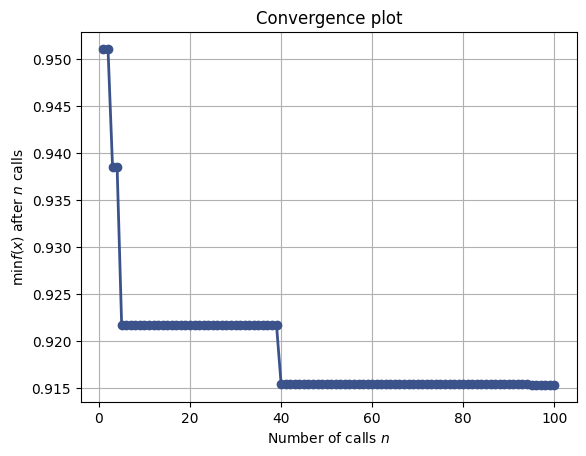

In [ ]:
# Extrair os valores de result.x
tokens = result.x[:num_tokens]
melhor_temp = round(result.x[num_tokens] / 1000, 3)
melhor_top_k = round(result.x[num_tokens + 1] / 1000, 3)
melhor_top_p = round(result.x[num_tokens + 2] / 1000, 3)
melhor_bleu = -result.fun

# Dividir os tokens em prefixo e sufixo (ex: metade para cada)
meio = num_tokens // 2
prefix_tokens = tokens[:meio]
suffix_tokens = tokens[meio:]

# Visualização e resultados
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence

print("===== RESULTADO =====")
print(f"Pre input:  {word_tokenize.decode(prefix_tokens)}")
print(f"Post input: {word_tokenize.decode(suffix_tokens)}")
print(f"Temperatura:  {melhor_temp}")
print(f"Top_k:        {melhor_top_k}")
print(f"Top_p:        {melhor_top_p}")
print(f"BLEU médio:   {melhor_bleu}")

plot_convergence(result)
plt.show()

In [ ]:
test_article = """
in [ 18 ] tierney and vogel for any functor @xmath0 , where @xmath1 is a category with finite limits and with a projective class @xmath2 , and @xmath3 is an abelian category , have constructed derived functors and investigated relationships of their theory with other theories of derived functors . 
 namely , they have shown that if @xmath1 is abelian and @xmath4 is additive , then their theory coincides with the classical relative theory of eilenberg - moore [ 7 ] , whereas if @xmath1 is abelian and @xmath4 is an arbitrary functor , then it gives a generalization of the theory of dold - puppe [ 6 ] . besides , they showed that their derived functors are naturally isomorphic to the cotriple derived functors of barr - beck [ 3 ] if there is a cotriple in @xmath1 that realizes the given projective class @xmath2 . 
 the key point in the construction of the derived functors by tierney and vogel is that , using @xmath2-projective objects and simplicial kernels , for every @xmath5 from @xmath1 a @xmath2-projective resolution can be constructed , which is an @xmath5-augmented pseudosimplicial object in @xmath1 and which for a given @xmath5 is unique up to a presimplicial homotopy ( according to the comparison theorem for @xmath2-projective resolutions ) . 
 a natural question arises about constructing a cubical analog of the theory of tierney and vogel . 
 exactly this is the purpose of this paper .    before turning to the content of the paper itself , 
 let us say few words about cubical objects and techniques . 
 as it is well known , simplicial methods are developed for long time and are successfully used in algebra and topology . with less success , but still also cubical techniques have been developed , which was initiated on one hand by the systematic use of singular cubes in the singular homology theory of topological spaces ( see , for example , [ 14 ] ) , and , on the other hand , by the papers of kan [ 12 , 13 ] which have related cubical sets to homotopy theory . 
 further research ( see e.  g. [ 1,2,4,5,8 - 11,16,17,19 ] ) has also shown that the cubical approach is interesting and important . 
 cubical objects have a number of advantages compared to the simplicial ones . 
 for example , a ( pre)cubical homotopy is given by a single morphism in each dimension , whereas a ( pre)simplicial homotopy requires `` many '' morphisms . on the other hand , 
 significant disadvantages of the cubical technique with respect to the simplicial one are also apparent . 
 for example , a cubical group , in fact even a cubical abelian group , can fail to satisfy the kan condition [ 16,17 ] . in the context of elimination of these and other disadvantages of the cubical theory , of extreme importance 
 are cubical objects with connections introduced by brown and higgins [ 4 ] . 
 these objects are cubical objects with extra degeneracies , called connections . 
 to stress importance and naturality of cubical objects with connections it suffices to name e.  g. the following three facts . 
 the singular cubical complex of any topological space has naturally defined connections . 
 next , tonks in [ 19 ] has shown that any cubical group with connections satisfies the kan condition . 
 finally , brown and higgins [ 5 ] have recently proved that the category of cubical objects with connections in an abelian category is equivalent to the category of nonnegative chain complexes in the same category .    in this paper 
 we introduce pseudocubical objects with pseudoconnections , obtained from the brown - higgins structure of a cubical object with connections by suitably relaxing their identities . 
 projective precubical resolutions which we are using to construct cubical derived functors possess pseudodegeneracies and pseudoconnections and this fact is essentially used in the construction of derived functors defined by us . 
 now let us list the contents of the paper by sections . 
 in section [ prelim ] we recall the notions of presimplicial , pseudosimplicial and simplicial objects , precubical , cubical objects and cubical objects with connections , their morphisms , and the respective augmented versions of these notions . 
 we also recall the definitions of normalization functors in the simplicial setting by moore , and in the cubical setting by wiatek [ 16 ] . 
 furthermore we recall the kan cubical sets and their homotopy groups .    for any presimplicial object @xmath6 in an abelian category @xmath1 the normalized chain complex of @xmath6 , denoted by @xmath7 in this paper , is a chain subcomplex of the unnormalized chain complex of @xmath6 , denoted by @xmath8 . 
 the well known moore theorem says that if @xmath6 is a simplicial object in @xmath1 , then this inclusion is a chain homotopy equivalence ( in fact this is valid for any pseudosimplicial object in @xmath1 ) . on the other hand , for any precubical object @xmath9 in an abelian category @xmath1 , one has the canonical inclusion @xmath10 of chain complexes @xmath11 and @xmath12 in @xmath1 which are cubical analogs of @xmath7 and @xmath8 ( see [ 16 , 17 ] ) respectively , and which functorially depend on @xmath9 . in section 2 
 we introduce pseudocubical objects with pseudoconnections and prove that @xmath13 is a chain homotopy equivalence for any pseudocubical object @xmath9 with pseudoconnections ( in particular for any cubical object @xmath9 with connections ) . 
 thus we obtain a cubical analog of the moore theorem . 
 then we establish some results which are not needed later on ; however they seem interesting by themselves . 
 let us mention some of them . 
 we indicate an alternative proof of the aforementioned brown - higgins equivalence . furthermore , we point out that this equivalence is realized by the above functor @xmath14 . 
 next , we show that if @xmath15 is a kan cubical group , then @xmath16 , the @xmath17-th homotopy group of @xmath15 , coincides with @xmath18 , the @xmath17-th homology group of @xmath19 ( note that @xmath19 and @xmath18 are defined for any cubical group @xmath15 as well ) . using this and the cubical analog of the moore theorem together with the aforementioned result of tonks 
 , we get that @xmath16 is naturally isomorphic to @xmath20 for any cubical abelian group @xmath15 with connections . 
 let @xmath1 be a category with finite limits and a projective class @xmath2 , @xmath3 an abelian category , and @xmath0 an arbitrary ( covariant ) finctor . in section 3 
 we construct left cubical derived functors @xmath21 , @xmath22 , @xmath23 , as follows . 
 first we show how to build for any object @xmath5 from @xmath1 an @xmath5-augmented @xmath2-projective precubical resolution , denoted @xmath24 , by means of cubical kernels and @xmath2-projective objects 
 . then we prove the comparison theorem which in particular says that @xmath24 is unique up to precubical homotopy for a given @xmath5 . 
 furthermore , it is shown that any @xmath2-projective precubical resolution @xmath24 is in fact an augmented pseudocubical object with pseudoconnections . 
 we define @xmath25 , @xmath23 , to be the @xmath17-th homology of @xmath26 . 
 besides the comparison theorem , the fact that @xmath27 has pseudodegeneracies is crucial in proving that @xmath25 are well - defined and functorially depend on @xmath5 . 
 this contrasts with the construction of the derived functors by tierney and vogel which does not use existence of pseudodegeneracies in @xmath2-projective presimplicial resolutions ( pseudodegeneracies of @xmath2-projective presimplicial resolutions are essentially used when the theory of tierney and vogel is compared with other theories of derived functors ) . 
 further , we define @xmath28 , @xmath23 , to be the @xmath17-th homology group of @xmath29 . 
 now this construction essentially uses the fact that @xmath27 is a pseudocubical object with pseudoconnections , i.  e. , this is crucial for proving that @xmath30 are well - defined and functorial in @xmath5 . 
 the cubical analog of the moore theorem proved in the previous section shows that in fact there are isomorphisms @xmath31 , @xmath23 , which are natural in @xmath5 and @xmath4 . 
 suppose @xmath1 is an abelian category with a projective class @xmath2 , @xmath3 an abelian category , and @xmath0 an additive ( covariant ) functor . 
 then one constructs , with respect to @xmath2 , the left derived functors @xmath32 ( @xmath23 ) of @xmath4 in the sense of eilenberg - moore [ 7 ] . on the other hand , 
 since any abelian category admits finite limits , we can build @xmath2-projective precubical resolutions , and therefore can construct the cubical left derived functors @xmath33 , @xmath23 . in section 4 , using once again the cubical analog of the moore theorem , we prove that if @xmath2 is closed [ 7 ] or , more generally , is closed with respect to retracts , then there are isomorphisms @xmath34 , @xmath35 , @xmath23 , which are natural in @xmath5 and @xmath4 . 
 we begin with the following known definitions . 
 a presimplicial object @xmath6 in a category @xmath1 is a family of objects @xmath36 together with face @xmath1-morphisms @xmath37    a morphism @xmath38 between presimplicial objects in a category @xmath1 is a family of @xmath1-morphisms @xmath39 which commute with the face operators . 
 if @xmath9 and @xmath40 are ( pseudo)simplicial objects , then the @xmath1-morphisms @xmath41 must commute with the face and ( pseudo)degeneracy operators .    a precubical object @xmath9 in a category @xmath1 is a family of objects @xmath42 together with @xmath1-morphisms @xmath43 satisfying @xmath44 the @xmath1-morphisms @xmath45 and @xmath46 are called face operators .    a cubical object @xmath9 in a category @xmath1 is a family of objects @xmath47 together with @xmath1-morphisms @xmath48 as above and @xmath49 which satisfy @xmath50 where @xmath51 . 
 the @xmath1-morphisms @xmath52 are called degeneracy operators . 
 [ [ 4 ] ] a cubical object @xmath9 in a category @xmath1 is said to have connections if there are given @xmath1-morphisms @xmath53 satisfying @xmath54    the singular cubical complex @xmath55 of a topological space @xmath9 is a cubical object with connections in the category of sets . 
 the connections @xmath56 are defined by @xmath57^n\to x\right)(t_1,t_2, ... ,t_{n+1})=f(t_1, ... ,t_{i-1},\max(t_i , t_{i+1}),t_{i+2}, ... ,t_{n+1}).\ ] ]    a morphism @xmath38 between precubical objects in a category @xmath1 is a family of @xmath1-morphisms @xmath39 which commute with the face operators . if @xmath9 and @xmath40 are cubical objects , then the @xmath1-morphisms @xmath41 must commute with the face and degeneracy operators ; and if @xmath9 and @xmath40 are cubical objects with connections , then the @xmath1-morphisms @xmath41 must commute with the faces , degeneracies and connections .    for any category @xmath1 , 
 let us denote by @xmath58 the category of presimplicial objects in @xmath1 , by @xmath59 the category of precubical objects in @xmath1 , by @xmath60 the category of cubical objects in @xmath61 , and by @xmath62 the category of cubical objects with connections in @xmath1 . 
 let @xmath1 be an abelian category , and @xmath63 the category of non - negatively graded chain complexes in @xmath1 . 
 we essentially use the normalization functor @xmath64 of wiatek [ 16 , 17 ] which is constructed as follows . 
 if @xmath65 and @xmath66 is a precubical morphism , then define @xmath67    of less importance for us is the functor @xmath68 which is defined for arbitrary abelian category @xmath1 by @xmath69 ( see [ 16 , 17 ] ) . 
 let @xmath1 be again an abelian category . 
 recall the definition of the moore normalization functor @xmath70 assume @xmath6 , @xmath71 and @xmath72 is a presimplicial morphism . 
 then @xmath73 one also has the functor @xmath74 assigning to @xmath75 its unnormalized chain complex . 
 more precisely , @xmath76    an augmented precubical ( resp . 
 presimplicial ) object in a category @xmath1 is a precubical ( resp . 
 presimplicial ) object @xmath9 in @xmath1 together with an object @xmath35 and an @xmath1-morphism @xmath77 satisfying @xmath78 ( resp . 
 @xmath79 ) . 
 such an object is denoted by @xmath80 . 
 a morphism between @xmath80 and @xmath81 is a morphism @xmath82 between @xmath9 and @xmath40 together with an @xmath1-morphism @xmath83 satisfying @xmath84 . 
 denote the category of augmented precubical ( resp . 
 presimplicial ) objects in @xmath1 by @xmath85 ( resp . 
 @xmath86 ) , by @xmath87 the category of augmented pseudosimplicial objects in @xmath1 , and by @xmath88 the category of augmented simplicial objects in @xmath1 . 
 assume @xmath1 is abelian . 
 then a nonnegative chain complex in @xmath1 augmented over @xmath35 is a nonnegative chain complex @xmath9 in @xmath1 together with an @xmath1-morphism @xmath77 satisfying @xmath89 . 
 denote the category of augmented nonnegative chain complexes in @xmath1 by @xmath90 . 
 for any abelian category @xmath1 , the functor @xmath91 , respectively the functors @xmath92 , @xmath93 extend in an obvious way to @xmath94 respectively @xmath95    let @xmath1 be an abelian category . using the shifting functor @xmath96 ( assigning to @xmath97 the nonnegative chain complex @xmath98 defined by @xmath99 , @xmath100 , @xmath101 , @xmath102 ) , we get functors @xmath103 and @xmath104 the restrictions of which to the category of augmented pseudosimplicial objects are used in the next section . 
 next recall [ 12 ] the definition of the homotopy groups of a kan cubical set . 
 a cubical set @xmath9 is said to be kan if for any @xmath105 , any @xmath106 and any collection of @xmath107 elements @xmath108 , @xmath109 , @xmath110 , @xmath111 , satisfying @xmath112 there exists @xmath113 such that @xmath114    let @xmath9 be a cubical set , @xmath115 and @xmath108 , @xmath102 , @xmath109 , @xmath110 . 
 we write @xmath116 iff @xmath117 , @xmath109 , @xmath110 . 
 suppose now that @xmath118 is a kan cubical set with a basepoint @xmath119 . 
 let @xmath120 and define an equivalence relation @xmath121 on @xmath122 @xmath123 by @xmath124 or equivalently , by @xmath125 [ 12 , theorem 6 ] . 
 denote @xmath126 , @xmath127 . 
 let @xmath128,[y]\in\pi_n(x,\psi)$ ] @xmath129=cl_\sim(x))$ ] , @xmath102 . 
 since @xmath9 is kan , there is @xmath130 with @xmath131 clearly , @xmath132 . 
 define @xmath128\bl[y]=[\pa_1 ^ 1z]$ ] . 
 this definition depends only on the equivalence classes of @xmath133 and @xmath134 and , with this multiplication , @xmath135 , @xmath102 , is a group , called the @xmath17-th homotopy group of @xmath118 . 
 finally let us note that in the text we will freely make use of the freyd - mitchell embedding theorem ( see e.  g. [ 20 , p.25 ] ) when applying various results in the literature about modules to objects in general abelian categories . 
 let @xmath15 be a cubical group and define @xmath136 then :    1 . 
 @xmath137 , @xmath127 . 
 2 .   @xmath138 , @xmath139 . 
 3 .   @xmath140 is a normal subgroup of @xmath141 and of @xmath142 , @xmath127 . 
 let @xmath143 . by definition @xmath144 consequently , @xmath145 . 
 hence ( a ) is proved . 
 . then @xmath146 . using this we get @xmath147 . 
 hence ( b ) is proved . 
 suppose @xmath148 and @xmath149 . 
 obviously one has @xmath150 and @xmath151 . 
 this proves ( c ) . 
 thus , for any cubical group @xmath15 , @xmath152 is a chain complex of ( not necessarily abelian ) groups . 
 we call @xmath19 the moore chain complex of @xmath15 . 
 it is obvious that @xmath19 and its homology groups @xmath153 functorially depend on @xmath15 . 
 obviously , in the construction of @xmath19 one may replace @xmath15 by a precubical object @xmath9 in an abelian category ( in [ 16 ] @xmath19 is introduced for cubical objects in an abelian category ) . 
 in this case we redefine the differential @xmath154 on @xmath11 by @xmath155 . 
 then @xmath11 is a chain subcomplex of @xmath12 and one has a natural monomorphism @xmath156 . 
 + 4 mm    now let us introduce pseudocubical objects and pseudocubical objects with pseudoconnections . 
 + 4 mm    a pseudocubical object @xmath9 in a category @xmath1 is a family of objects @xmath42 together with face @xmath1-morphisms @xmath157 for @xmath51 . 
 we say that a pseudocubical object @xmath9 in a category @xmath1 has pseudoconnections if there are given @xmath1-morphisms @xmath53 which satisfy @xmath158    morphisms of pseudocubical objects and pseudocubical objects with pseudoconnections are defined in an obvious way , just as for cubical objects and cubical objects with connections .    for a category @xmath1 , 
 let us denote by @xmath159 the category of pseudocubical objects with pseudoconnections in @xmath1 . 
 let @xmath1 be an abelian category . 
 define the functor @xmath160 as follows : @xmath161 on the other hand , we have the functors @xmath162 and @xmath163 from @xmath87 to @xmath164 . 
 one can easily see that @xmath165    let @xmath15 be a simplicial object in an abelian category @xmath1 . 
 then the normalized chain complex @xmath166 of @xmath15 is a chain subcomplex of the unnormalized chain complex @xmath167 of @xmath15 . 
 the moore theorem says that this inclusion is a chain homotopy equivalence . 
 the proof of this theorem [ 15 , p.94 ] does not use the simplicial identity : @xmath168 , @xmath169 . 
 therefore one may assert that for any augmented pseudosimplicial object @xmath6 in an abelian category @xmath1 , the natural monomorphism @xmath170 is a chain homotopy equivalence . 
 replacing now @xmath6 by @xmath171 , where @xmath9 is a pseudocubical object with pseudoconnections in @xmath1 , and using @xmath172 and @xmath173 , we get a cubical analog of the moore theorem :    [ normtheo ] let @xmath9 be a pseudocubical object with pseudoconnections in an abelian category . then the natural monomorphism @xmath156 is a chain homotopy equivalence and , therefore , @xmath174 is an isomorphism for all @xmath23 . 
 in fact @xmath156 has a natural homotopy inverse @xmath175 with @xmath176 ( see the proof of theorem 22.1 of [ 15 ] ) . 
 note that the natural monomorphism @xmath177 need not be a chain homotopy equivalence for a cubical object @xmath9 with connections in an abelian category . 
 as is known the prime examples of pseudosimplicial objects are the projective resolutions used by tierney and vogel to define their derived functors . in the next section we construct cubical analogs of tierney - vogel s projective resolutions ( in order to define our cubical derived functors ) and show that they have pseudodegeneracies and pseudoconnections . 
 the material in the rest of this section is not needed in what follows ; however we believe it is interesting for its own sake . 
 suppose that @xmath9 is a cubical object with connections in an abelian category @xmath1 . 
 then @xmath171 is an augmented simplicial object . 
 denote by @xmath178 the chain subcomplex of @xmath12 generated by the images of the degeneracies of @xmath171 . 
 since the degeneracy morphisms of @xmath171 are defined by @xmath179 , @xmath102 , @xmath180 , one has @xmath181 besides , @xmath182 and @xmath183 . 
 let @xmath9 be a cubical object with connections in an abelian category @xmath1 . 
 then :    1 . 
 @xmath184 and hence @xmath11 is isomorphic to @xmath185 . 
 the canonical projection @xmath186 is a chain homotopy equivalence .    as @xmath171 is an augmented simplicial object , one has @xmath187 ( where @xmath188 is the chain subcomplex of @xmath189 generated by the degenerate elements of @xmath171 ) , and the canonical projection @xmath190 is a chain homotopy equivalence ( see corollary 22.2 and 22.3 of [ 15 ] ) . but 
 @xmath191 , @xmath192 and @xmath193 . hence ( 
 a ) and ( b ) hold . 
 suppose @xmath9 is a cubical set with connections . 
 an n - cube @xmath194 is said to be folded if there exists @xmath195 such that @xmath196 for some @xmath197 ( see [ 1 ] ) . 
 when we define the singular cubical homology @xmath198 of a topological space @xmath4 , it is necessary to factor out the degenerate singular cubes . 
 it easily follows from theorem 2.5 that the folded singular cubes can be ignored in addition when we calculate @xmath198 . 
 let @xmath1 be an abelian category . 
 restricting @xmath14 and @xmath199 to the category @xmath62 , and @xmath200 to the category @xmath88 , we get the following commutative diagram @xmath201 ^ -{m}\ar[rd]_-{\ol{n}}&&ch_{\ge 0}(\sa)\\ & as(\sa)\ar[ru]_-{\wh{i}}}\ ] ] in which , by the dold - kan theorem , @xmath200 is an equivalence of categories . 
 moreover , the functor @xmath202 is also an equivalence . 
 the proof is very similar to the proof of the dold - kan theorem [ 20 , p.270 ] . 
 thus we have got an alternative proof of the result by brown and higgins [ 5 ] about the equivalence of the categories @xmath62 and @xmath164 . 
 furthermore , we have pointed out the functor @xmath203 which realizes this equivalence .    in 
 what follows , for pointed kan cubical monoids @xmath15 , we will always take the unit 1 of @xmath204 as basepoint , and denote @xmath205 by @xmath16 . 
 [ moorekan ] 
 let @xmath15 be a kan cubical monoid and suppose that @xmath105 . then :    \(a ) for any @xmath206 ,  @xmath128\bullet[y]=[xy]$ ] . 
 \(b ) @xmath16 is abelian .    to prove this proposition , we need the following well known    [ twoopers ] let @xmath207 and @xmath208 be binary operations on a set @xmath209 . 
 assume that they have units and satisfy @xmath210 for all @xmath211 . 
 then these operations coincide and @xmath212 is an abelian monoid . 
 the proofs of propositions 17.2 and 17.3 of [ 15 ] ) . using the monoid structure on @xmath15 
 , a binary operation may be defined on @xmath16 by @xmath128*[y]=[xy]$ ] . 
 this is well - defined . indeed , 
 if @xmath206 then @xmath213 , and if @xmath214 and @xmath215 , @xmath216 , i.  e. , @xmath217 then @xmath218 i.e. , @xmath219 . 
 next , assume that @xmath128,[y],[u],[v]\in\pi_n(g)$ ] . by the kan condition , there are @xmath220 with @xmath221 whence @xmath222 then , by the definitions of @xmath223 and @xmath208 , we can write @xmath224\bl[y]\right)*\left([u]\bl[v]\right)=[\pa_1 ^ 1w_1]*[\pa_1 ^ 1w_2][\pa_1 ^ 1w_1\cdot\pa_1 ^ 1w_2]=\\ = [ xu]\bl[yv]=\left([x]*[u]\right)\bl\left([y]*[v]\right).\end{gathered}\ ] ] besides , @xmath128\bl[1]=[x]=[1]\bl[x]$ ] and @xmath128*[1]=[x]=[1]*[x]$ ] . 
 consequently , we conclude , by lemma [ twoopers ] , that @xmath207 and @xmath208 coincide and @xmath16 is abelian . 
 [ kanpimoore ] for any _ kan _ cubical group @xmath15 , @xmath225    let us use the following notations : @xmath226 it is evident that @xmath227 for all @xmath127 . 
 therefore , in view of proposition [ moorekan ] , it suffices to show that @xmath228 if and only if @xmath229 , @xmath230 . 
 suppose that @xmath206 and @xmath228 . 
 then @xmath231 this gives @xmath128*[y^{-1}]=[xy^{-1}]=[1]$ ] , whence @xmath128=[y]$ ] , i.  e. , @xmath228 . 
 any cubical group with connections is kan [ 19 ] . 
 combining this with theorem [ normtheo ] and proposition [ kanpimoore ] , we get    for any cubical abelian group @xmath15 with connections , @xmath16 is naturally isomorphic to @xmath20 for all @xmath23 . 
 let @xmath1 be a category and @xmath232 a sequence of @xmath1-morphisms , @xmath102 . 
 a cubical kernel of the sequence @xmath233 is a sequence @xmath234 of @xmath1-morphisms such that    * @xmath235 for @xmath236 , @xmath237 ; *   * if @xmath238 is any other sequence satisfying identities @xmath239 for @xmath236 , @xmath237 , then there exists a unique @xmath1-morphism @xmath240 with @xmath241 , @xmath242 , @xmath243 . 
 it immediately follows from the definition that cubical kernels are unique up to isomorphism if they exist . 
 suppose @xmath1 has finite limits and let @xmath244 ^ -{f_1 ^ 0}\ar@<-0.5ex>[r]_-{f_1 ^ 1}&b}$ ] be a pair of @xmath1-morphisms . 
 consider the diagram @xmath245_-{f_1 ^ 1}\ar[r]^-{f_1 ^ 0}&b\\ a\ar[u]^-{f_1 ^ 
 0}\ar[d]_-{f_1 ^ 1}&&a\ar[u]_-{f_1 ^ 0}\ar[d]^-{f_1 ^ 1}\\ b&a\ar[l]_-{f_1 ^ 1}\ar[r]^-{f_1 ^ 0}&b.}\ ] ] by assumption , we have the limit diagram @xmath245_-{f_1 ^ 1}\ar[r]^-{f_1 ^ 0}&b\\ a\ar[u]^-{f_1 ^ 
 0}\ar[d]_-{f_1 ^ 1}&k\ar[l]_-{k_2 ^ 1}\ar[u]^-{k_1 ^ 0 } \ar[r]^-{k_2 ^ 0}\ar[d]_-{k_1 ^ 1}&a\ar[u]_-{f_1 ^ 0}\ar[d]^-{f_1 ^ 1}\\ b&a\ar[l]_-{f_1 ^ 1}\ar[r]^-{f_1 ^ 0}&b,}\ ] ] i.e. the sequence @xmath246 is a cubical kernel of the pair @xmath247 ^ -{f_1 ^ 
 0}\ar@<-0.5ex>[r]_-{f_1 ^ 1}&b}.\ ] ] clearly , in fact , one has    if @xmath1 admits finite limits , then cubical kernels exist in @xmath1 for any sequence @xmath248 and any @xmath102 . 
 let @xmath2 be a class of objects of @xmath1 . 
 recall [ 7 ] that an @xmath1-morphism @xmath83 is said to be @xmath2-epimorphic iff @xmath249 is surjective for all @xmath250 . also recall that @xmath2 is called a projective class if for each @xmath35 there exists a @xmath2-epimorphism @xmath251 with @xmath250 . 
 let @xmath2 be a projective class in @xmath1 , @xmath252 ^ -\pa&a}$ ] an augmented precubical object over @xmath35 , and suppose that @xmath1 has finite limits . by proposition 3.2 
 , we have a factorization @xmath253 ^ -{\pa_1 ^ 0}\ar@<-.9ex>[rr]_-{\pa_{n+1}^1 } \ar[dr]_-{e_{n+1 } } & { { } ^{{}^{\vdots}}}&\ x_n\ \ar@<1.5ex>[rr]^-{\pa_1 ^ 0}\ar@<-.9ex>[rr]_-{\pa_n^1}\ar[dr]_-{e_n } & { { } ^{{}^{\vdots}}}&**[r]x_{n-1}\ \cdots&\ \ 
 x_1\ar@<.5ex>[rr]^-{\pa_1 ^ 0}\ar@<-.5ex>[rr]_-{\pa_1 ^ 1}\ar[dr]_-{e_1 } & & x_0\ar[r]^-{\pa}&a \\ & k_{n+1}\ar@<1.2ex>[ur]^-{k_1 ^ 0}\ar@{}[ur]|-\ddots\ar@<-1.5ex>[ur]_-{k_{n+1}^1 } & & k_n\ar@<1.2ex>[ur]^-{k_1 ^ 0}\ar@{}[ur]|-\ddots\ar@<-1.5ex>[ur]_-{k_n^1 } & & & k_1\ar@<.5ex>[ur]^-{k_1 ^ 0}\ar@<-.5ex>[ur]_-{k_1 ^ 1}}\ ] ] where @xmath254 ^ -{k_1 ^ 0}\ar@<-0.5ex>[r]_-{k_1 ^ 1}&x_0}$ ] is a kernel pair of @xmath255 ^ -\pa&a}$ ] , and-1em @xmath256 a cubical kernel of @xmath257 for @xmath258 . 
 we say that    * @xmath252 ^ -\pa&a}$ ] is @xmath2-projective iff each @xmath259 ; * @xmath252 ^ -\pa&a}$ ] is @xmath2-exact iff @xmath154 and @xmath260 @xmath261 are @xmath2-epimorphic ; * @xmath252 ^ -\pa&a}$ ] is @xmath2-projective resolution of @xmath5 iff it is @xmath2-projective and @xmath2-exact . 
 obviously , if @xmath1 is a category with finite limits and a projective class @xmath2 , then each @xmath35 has a @xmath2-projective resolution . 
 moreover , the following comparison theorem shows that such a resolution is unique up to precubical homotopy equivalence . 
 [ precm ] let @xmath252 ^ -\pa&a}$ ] be @xmath2-projective and @xmath262 ^ -{\pa'}&a'}$ ] be @xmath2-exact . 
 then any @xmath1-morphism @xmath83 can be extended to a precubical morphism @xmath263 ^ -\pa\ar[dd]_-{\ol{f}}&&a\ar[dd]^-f\\ & & & & \\ 
 x'\ar[rr]^-{\pa ' } & & a'}\ ] ] over @xmath264 @xmath265i . 
 e. , @xmath266 and @xmath264 form a morphism of augmented precubical objects@xmath267 . 
 furthermore , any two such extensions are precubically homotopic . 
 that is , if @xmath268 are two extensions of @xmath264 , then there exist @xmath1-morphisms @xmath269 , @xmath127 , such that @xmath270    we construct the extension @xmath271 and show its uniqness up to precubical homotopy by induction on @xmath17 . 
 since @xmath272 is @xmath2-projective and @xmath273 is @xmath2-epimorphic , there is @xmath274 with @xmath275 . 
 next , one has @xmath276 . 
 therefore @xmath277 and @xmath278 for a uniquely defined @xmath279 . 
 as @xmath280 is @xmath2-projective and @xmath281 is @xmath2-epimorphic , there exists @xmath282 with @xmath283 , and we have @xmath284 and @xmath285 . 
 thus @xmath286 and @xmath287 are constructed . 
 inductively , suppose given @xmath1-morphisms @xmath288 for @xmath289 so that @xmath290 , @xmath291 , @xmath243 
 . then @xmath292 , @xmath236 , @xmath237 . 
 hence there is a unique @xmath293 such that @xmath294 , @xmath242 , @xmath243 . 
 since @xmath295 is @xmath2-projective and @xmath296 is @xmath2-epimorphic , there exists @xmath297 with @xmath298 . 
 then we have @xmath299 , @xmath300 , @xmath243 . 
 this completes the inductive step and proves the existence of @xmath266 . 
 now suppose @xmath301 is another extension of @xmath83 . 
 we want to construct @xmath302 with @xmath303 , @xmath304 , @xmath127 , and @xmath305 , @xmath306 , @xmath110 . for @xmath307 consider diagram @xmath308{\ x_0}\ar@{-->}[ddll]_-{h_0}\ar@{-->}[dddl]_-{q_0 } \ar[rr]^-\pa\ar@<1.2ex>[dd]^-{g_0}\ar@<.2ex>[dd]_-{f_0}&&a\ar[dd]^-f\\ \\ 
 x'_1\ar[dr]_-{e_1}&&**[r]{\ x'_0}\ar[rr]^-{\pa'}&&**[r]a'\;\;.\\ & * * [ r]k'_1\ar@<-1ex>[ur]^-{k_1 ^ 0}\ar@<-2ex>[ur]_-{k_1 ^ 1 } & & } \ ] ] as @xmath309 , there exists @xmath310 such that @xmath311 and @xmath312 . 
 next , since @xmath272 is @xmath2-projective and @xmath313 is @xmath2-epimorphic , there is @xmath314 with @xmath315 . 
 this and the two previous equalities give @xmath316 and @xmath317 . thus @xmath318 is constructed . 
 inductively , suppose given @xmath319 with the required properties . 
 @xmath320x_n\ar@{-->}[ddll]_-{h_n}\ar@{-->}[dddl]_-{q_n } \ar@<1.5ex>[rr]^-{\pa_1 ^ 0}\ar@<-1ex>[rr]_-{\pa_n^1 } \ar@<1.4ex>[dd]^-{g_n}\ar@<-0.2ex>[dd]_-{f_n } & { { } ^{{}^{\vdots}}}&**[r]x_{n-1 } \ar@<-.2ex>[dd]_-{f_{n-1}}\ar@<1.4ex>[dd]^-{g_{n-1 } } \ar@<0.7ex>[ddll]_{h_{n-1}}\\ \\ * * [ r]x'_{n+1}\ar[dr]_-{e_{n+1}}&&**[r]x'_n \ar@<1.5ex>[rr]^-{\pa_1 ^ 0}\ar@<-1ex>[rr]_-{\pa_n^1 } & { { } ^{{}^{\vdots}}}&**[r]x'_{n-1}\ .\\ & * * [ r]k'_{n+1 } \ar@<1.1ex>[ur]^-{k_1 ^ 0}\ar@{}[ur]|-\ddots\ar@<-1.6ex>[ur]_-{k_{n+1}^1 } } \ ] ] define @xmath321 , @xmath242 , @xmath110 , as follows : @xmath322 by the induction assumption , @xmath323 that is @xmath324 for @xmath236 , @xmath325 . 
 therefore @xmath326 , @xmath242 , @xmath110 , for a uniquely defined @xmath327 . since @xmath328 is @xmath2-projective and @xmath329 is @xmath2-epimorphic , 
 there is @xmath269 with @xmath330 . 
 now we have @xmath331 this finishes the inductive step and completes the proof of the theorem . 
 the following theorem is crucial for constructing our cubical derived functors . 
 [ resdeg ] suppose that @xmath332 ^ -{\pa_1 ^ 0}\ar@<-.9ex>[rr]_-{\pa_{n+1}^1 } \ar[dr]_-{e_{n+1 } } & { { } ^{{}^{\vdots}}}&\ p_n\ \ar@<1.5ex>[rr]^-{\pa_1 ^ 0}\ar@<-.9ex>[rr]_-{\pa_n^1}\ar[dr]_-{e_n } & { { } ^{{}^{\vdots}}}&**[r]p_{n-1}\ \cdots&\ \ 
 p_1\ar@<.5ex>[rr]^-{\pa_1 ^ 0}\ar@<-.5ex>[rr]_-{\pa_1 ^ 1}\ar[dr]_-{e_1 } & & p_0\ar[r]^-{\pa}&a \\ & k_{n+1}\ar@<1.2ex>[ur]^-{k_1 ^ 0}\ar@{}[ur]|-\ddots\ar@<-1.5ex>[ur]_-{k_{n+1}^1 } & & k_n\ar@<1.2ex>[ur]^-{k_1 ^ 0}\ar@{}[ur]|-\ddots\ar@<-1.5ex>[ur]_-{k_n^1 } & & & k_1\ar@<.5ex>[ur]^-{k_1 ^ 0}\ar@<-.5ex>[ur]_-{k_1 ^ 1}}\ ] ] is a @xmath2-projective resolution of @xmath35 . 
 then :    \(a )  @xmath27 has pseudodegeneracy operators , i.e. , there exist @xmath333 ,  @xmath127 ,  @xmath242 , satisfying @xmath334    as an immediate consequence we have    [ psec ] any @xmath2-projective resolution @xmath335 ^ -{\pa}&a}$ ] is an augmented pseudocubical object with pseudoconnections . 
 \(a ) as @xmath336 ^ -{k_1 ^ 0}\ar@<-0.5ex>[r]_-{k_1 
 ^ 1}&p_0}$ ] is a kernel pair of @xmath337 , there is @xmath338 such that @xmath339 and @xmath340 . on the other hand , 
 since @xmath341 is @xmath2-projective and @xmath313 is @xmath2-epimorphic , @xmath342 for some @xmath343 and we have @xmath344 and @xmath345 . 
 thus @xmath343 is constructed . 
 inductively , suppose given @xmath343 , @xmath346 with the required properties . 
 fix @xmath347 , @xmath348 , and define @xmath349 , @xmath242 , @xmath110 , by @xmath350 using the induction assumption , one checks that @xmath351 for @xmath352 , @xmath353 
 . then there exists @xmath354 such that @xmath355 , @xmath242 , @xmath110 . 
 since @xmath356 is @xmath2-projective and @xmath329 is @xmath2-epimorphic , there is @xmath357 with @xmath358 . 
 according to this , for @xmath359 and @xmath110 , one has @xmath360 thus we have constructed @xmath361 with the desired properties . 
 \(b ) define @xmath362 by @xmath363 , @xmath364 , @xmath365 and @xmath366 . 
 one verifies that @xmath367 , @xmath110 . 
 hence there exists @xmath368 such that @xmath369 , @xmath370 , @xmath110 . 
 as @xmath371 is @xmath2-projective and @xmath372 is @xmath2-epimorphic , @xmath373 for some @xmath374 , and we have @xmath375 next , assume that @xmath374 , @xmath376 with the required properties are constructed , and for any fixed @xmath347 , @xmath109 , define @xmath377 , @xmath242 , @xmath110 , as follows : @xmath378 by the induction assumption , @xmath379 , @xmath352 , @xmath353 . 
 consequently , there is @xmath380 such that , @xmath381 , @xmath242 , @xmath110 .    since @xmath356 is @xmath2-projective and @xmath329 is @xmath2-epimorphic , there exists @xmath382 with @xmath383 
 then , for @xmath359 and @xmath110 , one has @xmath384 thus we have constructed @xmath385 satisfying the desired properties . 
 let @xmath1 be an abelian category . 
 it is shown in [ 16 ] that the functor @xmath386 sends cubically homotopic morphisms to chain homotopic morphisms . 
 the proof , which we repeat here because of the completeness , shows that in fact one has    [ prechn ] let @xmath9 be a pseudocubical object and @xmath387 a precubical object in an abelian category @xmath1 , and @xmath388 precubical morphisms . if @xmath264 and @xmath389 are precubically homotopic @xmath265see theorem @xmath390 , then @xmath391 and @xmath392 are chain homotopic . 
 let @xmath393 be a precubical homotopy from @xmath264 to @xmath389 , and let @xmath394 denote the canonical monomorphism from @xmath395 to @xmath328 , @xmath127 . 
 one checks that @xmath396 , @xmath348 , @xmath127 . consequently 
 , we have morphisms @xmath397 clearly , @xmath398 further , for all @xmath102 , we have @xmath399 hence @xmath400 is a chain homotopy from @xmath391 to @xmath401 . 
 this proposition together with theorem 2.4 implies    [ prechm ] let @xmath9 and @xmath387 be pseudocubical objects with pseudoconnections in an abelian category @xmath1 , and @xmath388 precubical morphisms . if @xmath264 and @xmath389 are precubically homotopic , then @xmath402 and @xmath403 are chain homotopic . 
 we are now ready to introduce cubical derived functors . 
 let @xmath1 be a category with finite limits and a projective class @xmath2 , @xmath404 an abelian category , and @xmath405 an arbitrary ( covariant ) functor . 
 we construct the left cubical derived functors @xmath406 , @xmath127 , of @xmath4 as follows . if @xmath35 , choose ( once and for all ) a @xmath2-projective resolution @xmath407 and define @xmath408 theorem 3.3 and propositions 3.4(a ) and 3.6 show that the objects @xmath25 are independent ( up to natural isomorphism ) of the resolution chosen ( if @xmath409 is a second @xmath2-projective resolution and @xmath410 a precubical morphism extending @xmath411 , then @xmath412 are isomorphisms ) . 
 moreover , by the same statements , it is immediately clear that @xmath21 are defined on morphisms and are functors from @xmath1 to @xmath404 . besides , functoriality in the variable @xmath4 is obvious . 
 similarly , in view of theorem 3.3 , corollary 3.5 and proposition 3.7 , one can define functors @xmath413 by @xmath414 it follows from theorem 2.4 that in fact there are isomorphisms @xmath415 which are natural in @xmath5 and in @xmath4 .    as one sees the construction of @xmath21 essentially uses [ resdeg](a ) , and similarly @xmath416 essentially uses [ psec ] . 
 this contrasts with the fact that the construction of the derived functors by tierney and vogel does not use existence of pseudodegeneracies in @xmath2-projective presimplicial resolutions . on the other hand , as shown in [ 16 ] , the functor @xmath417 ( see section 1 ) sends precubically homotopic morphisms of precubical objects to chain homotopic morphisms ( cf . 
 propositions [ prechn ] and [ prechm ] ) . 
 this together with theorem [ precm ] allows us to conclude that one does not need proposition [ resdeg](a ) to prove that the functors @xmath418 where @xmath27 is a @xmath2-projective precubical resolution augmented over @xmath35 , are correctly defined . 
 but in this way one obtains `` bad '' derived functors by the following reason . 
 one can easily see that @xmath419 for any @xmath250 and any @xmath23 . 
 thus in general the higher ( @xmath139 ) derived functors @xmath420 do not vanish on @xmath2-projectives , i.  e. , the crucial property of derived functors is not satisfied . 
 in particular , there is no chance for @xmath420 to coincide with the classical derived functors for additive functors @xmath4 between abelian categories . at the same time , the derived functors @xmath21 and @xmath416 certainly vanish on @xmath2-projectives for @xmath139 , and in particular coincide with the classical derived functors for additive @xmath4 , as we will show below in theorem [ coinc ] . 
 suppose that @xmath1 is an abelian category and @xmath405 an additive functor . our aim is to compare @xmath421 @xmath123 with the derived functors of @xmath4 in the sense of eilenberg - moore [ 7 ] . 
 let @xmath1 be an abelian category with a projective class @xmath2 and suppose that @xmath252 ^ -{\pa}&a}$ ] is a precubical object in @xmath1 augmented over @xmath35 . if @xmath252 ^ -{\pa}&a}$ ] is @xmath2-exact , then its augmented moore chain complex @xmath422 is @xmath2-exact in the sense of eilenberg - moore @xmath423 $ ] . 
 that is , the sequence of abelian groups @xmath424 where @xmath425 and @xmath426 @xmath261 , is exact for any @xmath250 . 
 evidently , @xmath427 , @xmath127 . 
 besides , since @xmath77 is @xmath2-epimorphic , @xmath428 is surjective . 
 let @xmath429 be an @xmath1-morphism with @xmath430 and consider the diagram @xmath431_-{g'}\ar@{-->}@`{(-60,-20)}[dddl]_-\varphi\ar@<-1ex>[dd]_-{g}\ar@<1ex>[dd]^-0\\ \\ 
 x_1\ar@<0.8ex>[rr]^-{\pa_1 ^ 0}\ar@<-0.9ex>[rr]_-{\pa_1 ^ 1 } \ar[dr]_-{e_1}&&x_0\ar[r]^-\pa&a,\\ & k_1\ar@<1ex>[ur]^-{k_1 ^ 0}\ar@<-1ex>[ur]_-{k_1 ^ 1 } } \ ] ] where @xmath336 ^ -{k_1 ^ 0}\ar@<-0.5ex>[r]_-{k_1 ^ 1}&x_0}$ ] is a kernel pair of @xmath77 , and @xmath313 is @xmath2-epimorphic . as @xmath432 
 , there exists a unique @xmath433 such that @xmath434 and @xmath435 . 
 but @xmath436 for some @xmath437 , and we have @xmath438 and @xmath439 . 
 it then follows from the construction of @xmath11 that @xmath440 , where @xmath441 denotes the inclusion @xmath442 and @xmath443 is a uniquely defined @xmath1-morphism from @xmath444 to @xmath445 . 
 clearly , @xmath446 . 
 thus the sequence is exact at @xmath447 . 
 now assume that @xmath139 and @xmath448 is an @xmath1-morphism with @xmath449 . 
 denote the inclusion @xmath450 by @xmath451 and consider the diagram @xmath431_-{f'}\ar@{-->}@`{(-100,-20)}[dddl]_-\varphi\ar@<-1.4ex>[dd]_-{\varphi_1 ^ 0 } \ar@<1ex>[dd]^-{\varphi_{n+1}^1}&&\\ & & { { } ^{{}^{\dots}}}\\ x_{n+1}\ar@<1.6ex>[rr]^-{\pa_1 ^ 0}\ar@<-.9ex>[rr]_-{\pa_{n+1}^1 } \ar[dr]_-{e_{n+1}}&{{}^{{}^{\vdots } } } & x_n\ar@<1.6ex>[rr]^-{\pa_1 ^ 0}\ar@<-.9ex>[rr]_-{\pa_n^1}&{{}^{{}^{\vdots } } } & x_{n-1}\\ & k_{n+1}\ar@<1.1ex>[ur]^-{k_1 ^ 0}\ar@<-1.9ex>[ur]_-{k_{n+1}^1}\ar@{}[ur]|-\ddots } \ ] ] where @xmath452 is a cubical kernel of @xmath453 , @xmath329 is @xmath2-epimorphic , and @xmath454 one checks that @xmath455 consequently , there exists a unique @xmath456 such that @xmath457 , @xmath242 , @xmath110 . 
 since @xmath329 is @xmath2-epimorphic and @xmath250 , one has @xmath458 for some @xmath459 . 
 but then @xmath460 from this we conclude , by the construction of @xmath11 , that @xmath461 for a uniquely defined @xmath1-morphism @xmath462 . clearly , @xmath463 , whence @xmath464 . 
 let @xmath1 be an abelian category with a projective class @xmath2 and suppose that @xmath252 ^ -\pa&a}$ ] is a pseudocubical object with pseudoconnections in @xmath1 augmented over @xmath35 . if @xmath465 is @xmath2-exact , then the augmented chain complex @xmath466 ^ -\pa&a}$ ] is @xmath2-exact in the sense of eilenberg - moore .    for any pseudocubical object @xmath9 in an abelian category @xmath1 , one has @xmath1-morphisms @xmath467 defined by @xmath468 it is immediate that @xmath469 , @xmath139 , @xmath109 . 
 therefore , by the construction of @xmath12 , each @xmath470 factors as @xmath471 ^ -{\sg_n^x}\ar[dr]_-{\tau_n^x}&&x_n\\ & n_n(x)\ar@{^{(}->}[ur]_-{\nu_n^x}}\ ] ] where @xmath472 is the inclusion . 
 one can easily see that @xmath473 , i.e. , @xmath474 is a retraction for each @xmath17 ( see [ 16 , 17 ] ) . 
 this together with corollary 3.5 and proposition 4.2 gives    [ retr ] let @xmath1 be an abelian category with a projective class @xmath2 which is closed with respect to retracts . if @xmath335 ^ -\pa&a}$ ] is a @xmath2-projective precubical resolution of @xmath35 , then the augmented chain complex @xmath475 ^ -\pa&a}$ ] is a @xmath2-projective resolution of @xmath5 in the sense of eilenberg - moore @xmath423 $ ] . 
 now let @xmath1 be an abelian category with a projective class @xmath2 , @xmath404 an abelian category , and @xmath405 an additive ( covariant ) functor . 
 then one constructs , with respect to @xmath2 , the classical left derived functors @xmath476 , @xmath127 . on the other hand , 
 since any abelian category admits finite limits , we can build @xmath2-projective precubical resolutions , and therefore can construct the cubical left derived functors @xmath406 , @xmath127 . 
 let @xmath478^\pa&a}$ ] be a @xmath2-projective precubical resolution of @xmath35 . by proposition 3.4(a ) , @xmath27 has pseudodegeneracy operators . 
 then , as noted above , we have @xmath1-morphisms @xmath479 , @xmath480 with @xmath481 and @xmath482 . 
 the latter gives @xmath483 . 
 hence @xmath484 is an epimorphism and @xmath485 is a monomorphism . since @xmath4 is additive , @xmath486 . 
 consider the commutative diagram @xmath487 ^ -{\nu_n^{t(p)}}\\ t(p_n)\ar[ur]^-{\tau_n^{t(p)}}\ar[dr]_-{t(\tau_n^p)}\ar[rr]^-{t(\sg_n^p)\sg_n^{t(p)}}&&t(p_n)\;\;\;\\ & t(n_n(p))\;\;.\ar[ur]_-{t(\nu_n^p ) } } \ ] ] as @xmath488 and @xmath489 are epimorphisms , @xmath490 . 
 but @xmath491 is an inclusion and @xmath492 is a monomorphism . 
 hence @xmath493 and @xmath494 is an isomorphism for each @xmath17 . 
 one can easily see that these isomorphisms commute with the differentials and induce natural isomorphisms on the homologies . in view of proposition [ retr ] , @xmath475 ^ -\pa&a}$ ] 
 is a @xmath2-projective resolution of @xmath5 in the sense of eilenberg - moore . 
 consequently , @xmath495 . on the other hand , by the definition of @xmath21 , 
 thus we have isomorphisms @xmath497 which are natural in @xmath5 and in @xmath4 . 
 there remains an open question here . 
 we do not know whether the cubical derived functors introduced by us coincide with the tierney - vogel derived functors in full generality , or at least , with the dold - puppe derived functors in the particular case of an arbitrary ( not necessarily additive ) functor on an abelian category .
"""

test_sum = """
we introduce pseudocubical objects with pseudoconnections in an arbitrary category , obtained from the brown - higgins structure of a cubical object with connections by suitably relaxing their identities , and construct a cubical analog of the tierney - vogel theory of simplicial derived functors . the crucial point in the construction 
 is that projective precubical resolutions which are naturally used to define our cubical derived functors possess pseudodegeneracies and pseudoconnections . 
 the same fact is essentially used for proving that in the case of an additive functor between abelian categories , our theory coincides with the classical relative theory of derived functors by eilenberg - moore .
"""

melhor_temp = 1.031
melhor_top_p = 0.764
melhor_top_k = 0.819

max_tokens = len(word_tokenize(test_article).input_ids) ** (1/2)
max_tokens

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_11233/3254812439.py:1: SyntaxWarning: invalid escape sequence '\m'
  test_article = """


121.97130810153674

In [ ]:
texto_gerado = create_completion(
			"<<<<<<<<없 prolathe extras sku-navigationQU垂broker"+"\n"+
			test_article+"\n"+
			'<<<<<<<<없 prolathe extras sku-navigationQU垂broker',
   			max_tokens,
            melhor_temp,
            melhor_top_p,
            melhor_top_k
        )

print(texto_gerado)
calcular_bleu(
	texto_gerado, 
	test_sum
)

 , but I’m trying to see if I can contribute by using some combinations of exact equations and understanding this all better. The problem is that it's a bit too abstract right now, so maybe I should try focusing more on the mathematical aspects rather than getting bogged down in the technicalities of the problem.

Alright, I'm going to tackle this problem step by step, but first, I need to make sure I understand what’s being asked. It seems like we're dealing with derived functors and some specific morphisms between them. Let me try to break this down.

First, there's


0.987124816506178

In [ ]:
texto_gerado = create_completion(
			"text that needs to be summarized below+"+"\n"+
			test_article+"\n"+
			'summarize the text above',
   			max_tokens,
            melhor_temp,
            melhor_top_p,
            melhor_top_k
        )

print(texto_gerado)
calcular_bleu(
	texto_gerado, 
	test_sum
)

, giving a summary or
</think>

\boxed{The cubical derived functors are constructed using precubular resolutions and exact chain complexes, building upon classical results.}

\end{enumerate}

However, I need to construct more accurate mathematical statements.

1. Construct a short paragraph (2 points) stating that the construction follows from the given reference with references cited in the text.
2. Create an accurate but shorter paragraph for each of the two types of 2- and 35.

**Type A: Algebraic Theory**
1. Constructing the homological constructions:
   - Start


0.9535288920018601

In [ ]:
samples = reservoir.get_samples()
samples

[{'article': 'the property of many - body quantum systems to be in entangled , or inseparable , states is the object of significant constant interest @xcite . \n entanglement is the essentially quantum feature signifying the formation of new entities , the complexes of particles . if one would try to separate an individual particle from such complex by performing a measurement one would inevitably affect the states of other particles in the complex even if the direct interaction is absent .    because of their highly unusual , from the classical point of view , properties the entangled states attract attention from both purely scientific and application points of view . as a result , as a problem of special importance there is the problem of producing entangled states . \n for example , nowadays the most developed and widely used method of generating the entangled photons is the parametric down conversion @xcite , which is based on the two - photon radiative decay of excited states . \

In [ ]:
bleus = []
for i, ex in tqdm(enumerate(samples), total=len(samples)):
    texto_gerado = create_completion(
                "text that needs to be summarized below+"+"\n"+
                ex['article']+"\n"+
                'summarize the text above',
                len(word_tokenize(ex['article']).input_ids) ** (1/2),
                melhor_temp,
                melhor_top_p,
                melhor_top_k
            )
    bleu_score = calcular_bleu(texto_gerado, ex['abstract'])
    bleus.append(bleu_score)

bleu_medio = np.mean(bleus)
print("BASIC Promt",bleu_medio)

100%|██████████| 5/5 [02:03<00:00, 24.66s/it]

BASIC Promt 0.9923209242368667


In [ ]:
bleus = []
for i, ex in tqdm(enumerate(samples), total=len(samples)):
    texto_gerado = create_completion(
                "<<<<<<<<없 prolathe extras sku-navigationQU垂broker"+"\n"+
                ex['article']+"\n"+
                '<<<<<<<<없 prolathe extras sku-navigationQU垂broker',
                len(word_tokenize(ex['article']).input_ids) ** (1/2),
                melhor_temp,
                melhor_top_p,
                melhor_top_k
            )
    bleu_score = calcular_bleu(texto_gerado, ex['abstract'])
    bleus.append(bleu_score)

bleu_medio = np.mean(bleus)
print("BEST Promt",bleu_medio)

100%|██████████| 5/5 [02:01<00:00, 24.37s/it]

BEST Promt 0.9929770055976045


In [ ]:
texto_gerado = create_completion(
    prompt=(
        "You are an expert in creating prompts for LLMs.\n"
        "Receive two inputs:\n"
        "- ARTICLE: the full text of an article.\n"
        "- ABSTRACT: the text of the abstract for that article.\n"
        "Your task is to generate a single PROMPT that meets the following requirements:\n"
        "1. It only needs the ARTICLE as input for a subsequent LLM.\n"
        "2. It instructs the LLM to produce exactly the original ABSTRACT, without variations.\n"
        "3. It is clear, concise, and self-contained (not dependent on external context).\n"
        "Inputs:\n"
        f"ARTICLE:\n{test_article}\n"
        f"ABSTRACT:\n{test_sum}\n"
        "Expected output:\n"
        "Generate a PROMPT that, when applied to an LLM with only the ARTICLE as input, causes the model to generate exactly the ABSTRACT above."
    ),
    max_tokens=max_tokens,
    temperature=melhor_temp,
    top_p=melhor_top_p,
    top_k=melhor_top_k
)

print(texto_gerado)

 Then, for each item in the prompt ( including items like "the model generates exact abelian groups and relations", "the model can be used to compute algebraic topology such as homology and cohomology of spaces ..."), how would these items correspond to the prompts from the original 4- category?

The original 4
category results.

1. The model generated exactly the ABSTRACT.
2. The model could be used to compute exact abelian groups 
3. The model generated a finite subgroup in an abelian category with cohomology rings; each computation was done within each item
